# PROJEKT 2 - EAD - HUBERT GORECKI 147599

## FAZA 1
#### Celem projektu jest analiza datasetu Gender, Mental Illness, and Crime in the United States, 2004 (ICPSR 27521). Głównym celem jest analiza czynników wpływających na możliwość rozwoju depresji.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

#file_path = '27521-0001-Data.tsv'
#df = pd.read_csv(file_path, sep='\t')
df = pd.read_csv('cleaned_data.csv')

#### 1. Z całego zbioru danych wybrane zostają 17 cech, które potencjalnie mogą wpływać na ryzyko wystąpienia rozwoju. 

Jako główny wskaźnik depresji został wybrany DEPRESSIONINDEX - ADULT & YOUTH DEPRESSION INDEX, czyli 10 stopniowa skala depresji, na którą odpowiedziało 66.5% ankietowanych. Na jego podstawie stworzony zostanie model umożliwiający oszacowanie natężenia depresji.

In [2]:
selected_columns = [
    "ANYTXRXMDE", "DEPRESSIONINDEX", "DEPEPISODE", "MDELASTYR", 
    "CATAG2", "IRSEX", "NEWRACE2", 

    "MJANDCOKE", 
    "MJCOKELY",
    "ALCFMFPB", 

    "EDU_DUMMY", 

    "INCOME", 
    "IRPRVHLT", "WORKFORCE", 

    "REVERSEPOP",

    "CRIMEHIST", 
    "ANYATTACK", "ANYTHEFT",

    "HEALTH2", 

    "MARRIED", "CHILDRENINHOME"
]

df = df[selected_columns]

Dane zostają oczyszczone z wierszy, w których występuje brak odpowiedzi na konkretne pytanie. Dodatkowo cecha dotycząca spożywania alkoholu *ALCFMFPB* zostaje uproszczona do dwóch odpowiedzi. 

In [3]:
missing_values = [-9, -1, "Missing", "Blank", "Unknown"]

for column in df.columns:
    df = df[~df[column].isin(missing_values)]

df = df[~df["ALCFMFPB"].isin([98, 97, 94, 83])]
df["ALCFMFPB"] = df["ALCFMFPB"].replace({91: 2, 93: 2})

df.to_csv('cleaned_data.csv', index=False)
df = df[~df["ALCFMFPB"].isin([98, 97, 94, 83])]
df["ALCFMFPB"] = df["ALCFMFPB"].replace({91: 2, 93: 2})

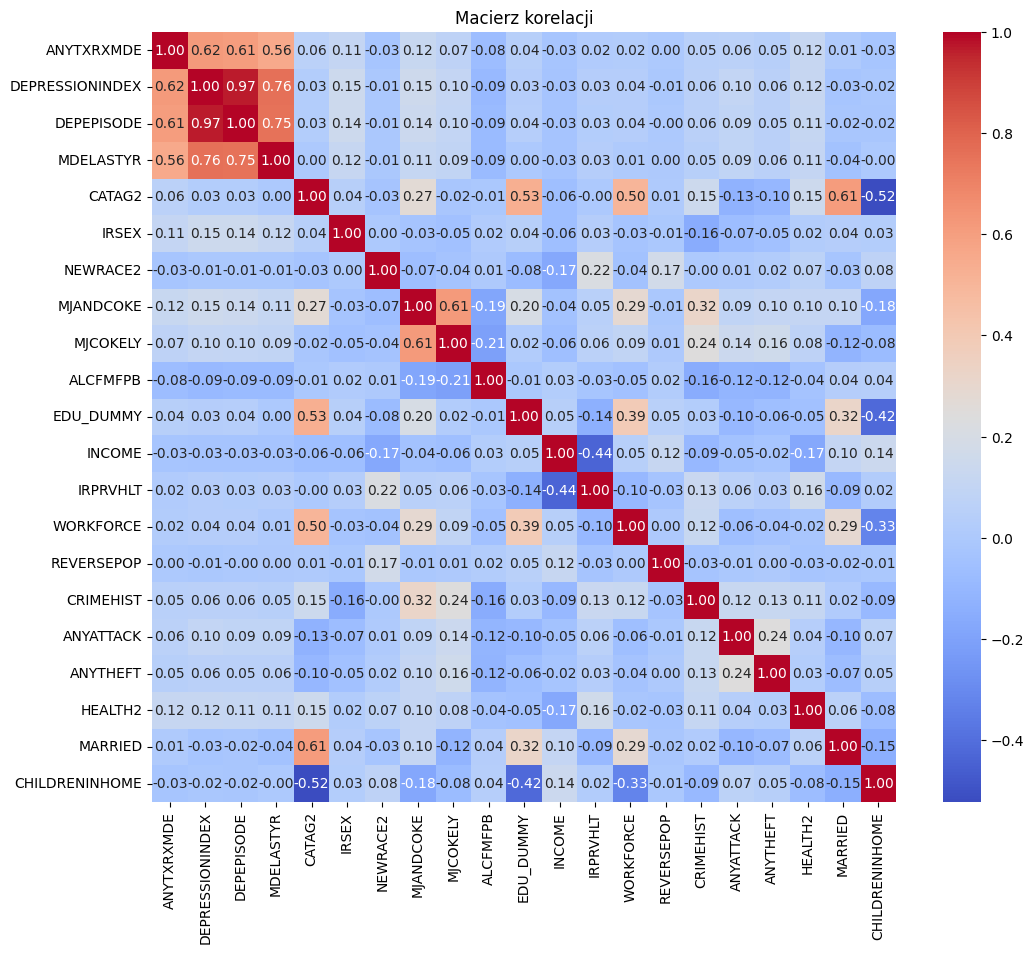

In [4]:
# Obliczenie macierzy korelacji
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Macierz korelacji")
plt.show()

Korelacja jest odpowiednia dla zmiennych liczbowych, ale w przypadku zmiennych kategorycznych, takich jak te, korelacja wydaje się nie być idealnym rozwiązaniem. W związku z czym użyty zostanie algorytm selekcji cech *(feature selection)* opartego na statystykach testu chi-kwadrat dla zmiennych kategorycznych oraz testu wzajemnej informacji *(mutual information)*. Jest to miara zależności pomiędzy dwiema zmiennymi. Działa zarówno dla zmiennych kategorycznych, jak i liczbowych, i pozwala określić, które cechy są najbardziej skorelowane z celem.

In [5]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

X = df.drop(columns=["DEPRESSIONINDEX", "DEPEPISODE", "MDELASTYR", "ANYTXRXMDE"])
y = df["DEPRESSIONINDEX"]  # Zmienna docelowa

# Mutual information
mutual_info = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual Information": mutual_info})
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)
print("Najważniejsze cechy wpływające na DEPRESSIONINDEX wg mutual:")
print(mi_df.head(10))

print("=======================================================")

# Chi-kwadrat
chi_scores, p_values = chi2(X, y)
chi_df = pd.DataFrame({"Feature": X.columns, "Chi-Square": chi_scores, "p-value": p_values})
chi_df = chi_df.sort_values(by="Chi-Square", ascending=False)
print("Najważniejsze cechy wpływające na DEPRESSIONINDEX wg chi_2:")
print(chi_df.head(10))

Najważniejsze cechy wpływające na DEPRESSIONINDEX wg mutual:
      Feature  Mutual Information
1       IRSEX            0.014884
3   MJANDCOKE            0.011737
5    ALCFMFPB            0.008097
14    HEALTH2            0.006714
8    IRPRVHLT            0.006323
11  CRIMEHIST            0.005536
4    MJCOKELY            0.004339
9   WORKFORCE            0.004069
13   ANYTHEFT            0.003757
0      CATAG2            0.003601
Najważniejsze cechy wpływające na DEPRESSIONINDEX wg chi_2:
      Feature  Chi-Square        p-value
3   MJANDCOKE  528.760447  3.972378e-108
12  ANYATTACK  361.450614   2.261330e-72
4    MJCOKELY  337.691647   2.575163e-67
14    HEALTH2  207.693326   8.061922e-40
13   ANYTHEFT  164.246312   9.728088e-31
11  CRIMEHIST  134.888294   1.169024e-24
1       IRSEX  133.676690   2.076890e-24
6   EDU_DUMMY   88.496426   3.259520e-15
9   WORKFORCE   48.599979   1.972436e-07
15    MARRIED   41.641379   3.821579e-06


Na tej podstawie wybranych zostaje 8 cech *(factors)*, dla których sprawdzone zostanie jak te czynniki zmieniają się w zależności od grupy wiekowej i od płci.

*factors = ['MJANDCOKE', 'ALCFMFPB', 'HEALTH2', 'IRPRVHLT', 'CRIMEHIST', 'WORKFORCE', 'ANYATTACK', 'EDU_DUMMY']*


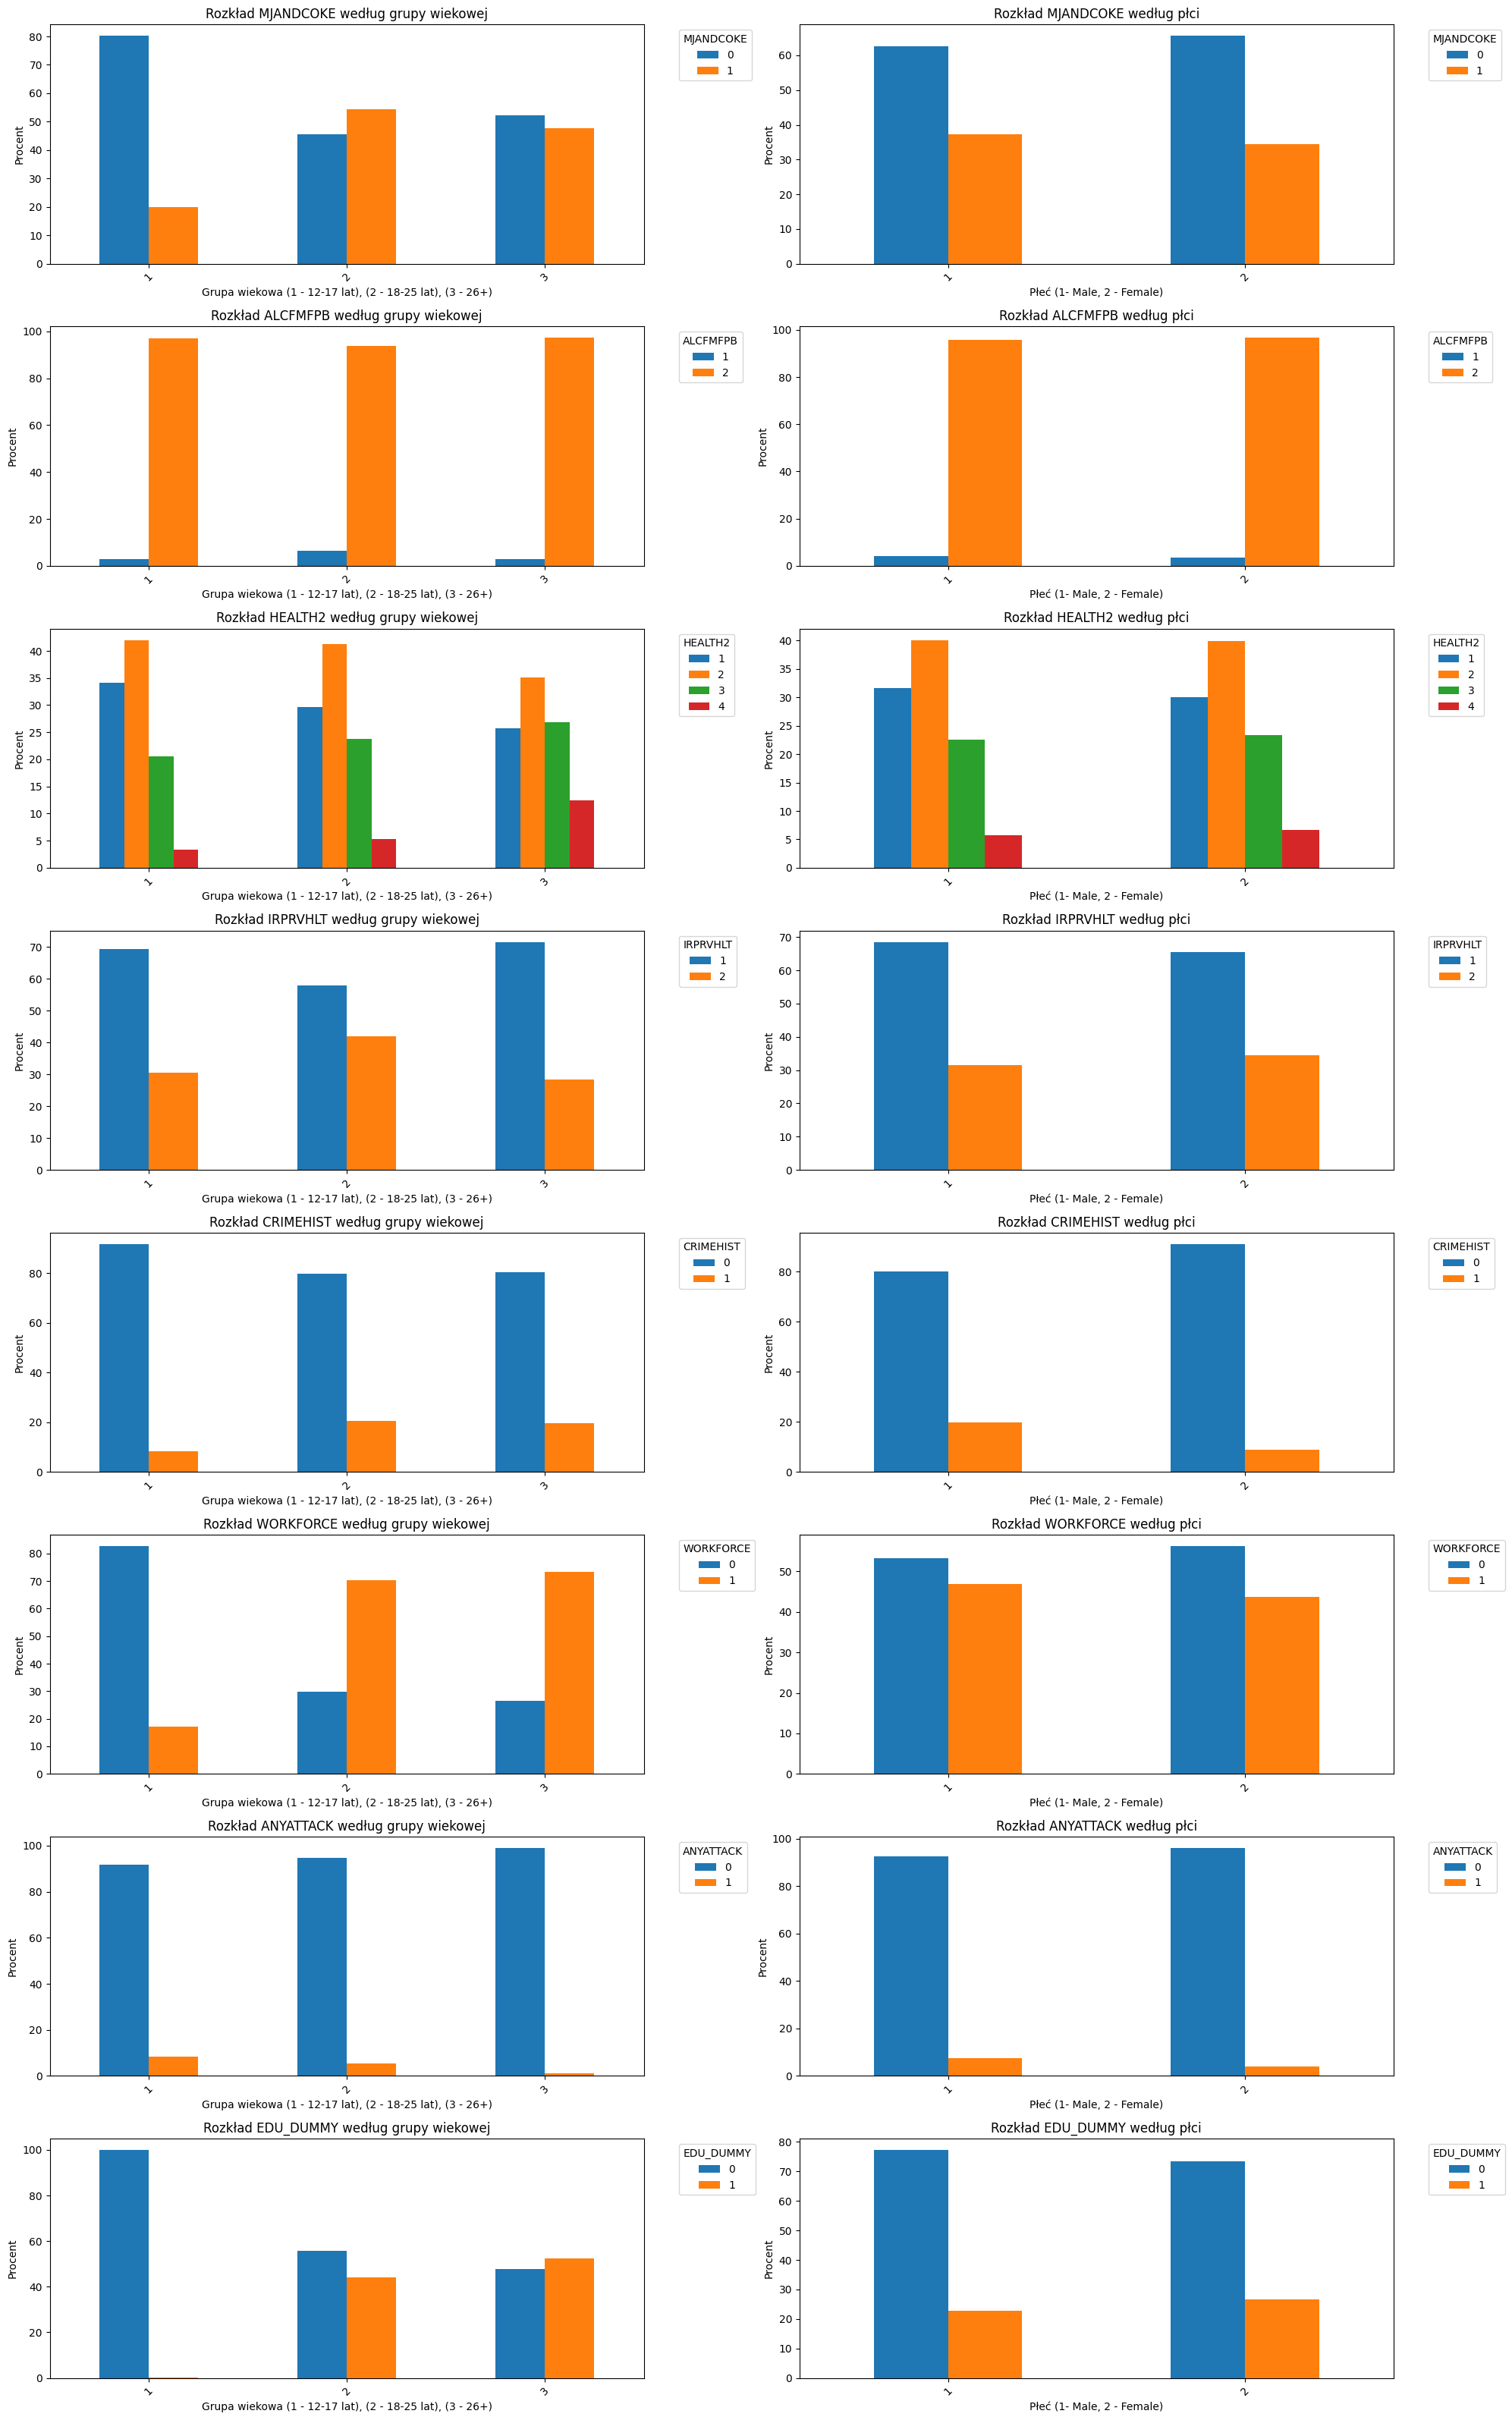

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_factor_distribution(df_clean, factors, age_col='CATAG2', sex_col='IRSEX'):
    fig, axes = plt.subplots(len(factors), 2, figsize=(20, 4*len(factors)))

    for i, factor in enumerate(factors):
        # Rozkład w grupach wiekowych
        age_dist = df_clean.groupby([age_col, factor]).size().unstack(fill_value=0)
        age_dist_percent = age_dist.div(age_dist.sum(axis=1), axis=0) * 100
        age_dist_percent.plot(kind='bar', stacked=False, ax=axes[i, 0])  # stacked=False dla obok siebie
        axes[i, 0].set_title(f'Rozkład {factor} według grupy wiekowej')
        axes[i, 0].set_xlabel('Grupa wiekowa (1 - 12-17 lat), (2 - 18-25 lat), (3 - 26+)')
        axes[i, 0].set_ylabel('Procent')
        axes[i, 0].tick_params(axis='x', rotation=45)
        axes[i, 0].legend(title=factor, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Rozkład według płci
        sex_dist = df_clean.groupby([sex_col, factor]).size().unstack(fill_value=0)
        sex_dist_percent = sex_dist.div(sex_dist.sum(axis=1), axis=0) * 100
        sex_dist_percent.plot(kind='bar', stacked=False, ax=axes[i, 1])  # stacked=False dla obok siebie
        axes[i, 1].set_title(f'Rozkład {factor} według płci')
        axes[i, 1].set_xlabel('Płeć (1- Male, 2 - Female)')
        axes[i, 1].set_ylabel('Procent')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].legend(title=factor, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

factors = ['MJANDCOKE', 'ALCFMFPB', 'HEALTH2', 'IRPRVHLT', 'CRIMEHIST', 'WORKFORCE', 'ANYATTACK', 'EDU_DUMMY']
visualize_factor_distribution(df, factors)

**MJANDCOKE (Użycie marihuany lub kokainy)** - Młodsze grupy wiekowe (12–17) rzadziej deklarują użycie narkotyków niż starsi. Mężczyźni częściej deklarują użycie tych substancji niż kobiety.

**ALCFMFPB** - Grupa wiekowa 18-25 lat deklaruje największy odsetek spożywania alkoholu. Różnice między płciami są niewielkie – zarówno kobiety, jak i mężczyźni rzadko zgłaszają takie problemy.

**HEALTH2** - Zdrowie oceniane jako "doskonałe" jest najczęściej zgłaszane przez młodsze grupy wiekowe. Wraz z wiekiem rośnie ilość problemów zdrowotnych. Różnice między płciami są niewielkie. 

**IRPRVHLT** - Najmniejszy odsetek osób posiadających prywatne ubezpieczenie zdrowotne jest w kategorii wiekowej 19-25 lat. Kobiety nieznacznie częściej deklarują posiadanie ubezpieczenia w porównaniu do mężczyzn.

**CRIMEHIST** - Odsetek osób z historią aresztowań rośnie wraz z wiekiem. Mężczyźni częściej niż kobiety mają historię aresztowań.

**WORKFORCE** - Najmłodsza grupa (12–17) najrzadziej deklaruje chodzenie do pracy. Brak wyraźnych różnic w zatrudnieniu między mężczyznami a kobietami.

**ANYATTACK** - Ataki na inne osoby są najczęstsze w najmłodszej grupie wiekowej, wartość ta maleje z wiekiem. Mężczyźni częściej niż kobiety deklarują takie zachowania.

**EDU_DUMMY** - Starsze grupy wiekowe (26+) częściej mają wykształcenie wyższe niż średnie w porównaniu do młodszych grup. Kobiety i mężczyźni wykazują podobny poziom wykształcenia.

## FAZA 2

### W fazie tej wykorzystane zostaną wnioski z fazy I do budowy modelu regresyjnego OLS umożliwiającego oszacowanie natężenia depresji u danej osoby.

Dane są najpierw podzielone na zbiór treningowy i walidacyjny, a następnie zrównoważone przez oversampling próbki osób z depresją. Model OLS jest trenowany na zrównoważonym zbiorze, a następnie ocenia się jego skuteczność na zbiorze walidacyjnym (AUC, dokładność). Predykcje modelu są używane do przypisania klas (depresja/brak depresji) 

In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Definicja zmiennej celu (klasyfikacja: 1 - depresja, 0 - brak depresji)
df["DEPRESSION_CLASS"] = (df["DEPRESSIONINDEX"] > 4).astype(int)

X = df.drop(columns=["DEPRESSIONINDEX", "DEPRESSION_CLASS"])
y = df["DEPRESSION_CLASS"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

df_train = X_train.copy()
df_train["DEPRESSION_CLASS"] = y_train
df_val = X_val.copy()
df_val["DEPRESSION_CLASS"] = y_val

# Zwiększenie liczności klasy z depresją
depression_class_1 = df_train[df_train["DEPRESSION_CLASS"] == 1]
depression_class_0 = df_train[df_train["DEPRESSION_CLASS"] == 0]
depression_class_1_oversampled = depression_class_1.sample(len(depression_class_0), replace=True, random_state=42)
df_train_balanced = pd.concat([depression_class_1_oversampled, depression_class_0])

# Model OLS na zrównoważonym zbiorze
formula = "DEPRESSION_CLASS ~ MJANDCOKE + ALCFMFPB + HEALTH2 + IRPRVHLT + CRIMEHIST + WORKFORCE + ANYATTACK + EDU_DUMMY + IRSEX + CATAG2"
ols_model_balanced = smf.ols(formula=formula, data=df_train_balanced).fit()
print(ols_model_balanced.summary())
ols_preds_balanced = ols_model_balanced.predict(df_val)
ols_class_preds_balanced = (ols_preds_balanced > 0.5).astype(int)
ols_auc_balanced = roc_auc_score(y_val, ols_preds_balanced)
ols_accuracy_balanced = accuracy_score(y_val, ols_class_preds_balanced)
print(f"OLS AUC (Balanced): {ols_auc_balanced:.2f}, Accuracy (Balanced): {ols_accuracy_balanced:.2f}")
print("OLS Classification Report (Balanced):")
print(classification_report(y_val, ols_class_preds_balanced))

test_results = pd.DataFrame({
    'predicted_prob': ols_preds_balanced,
    'depression_binary': y_val 
})

test_results['MJANDCOKE'] = df_val['MJANDCOKE']
test_results['ALCFMFPB'] = df_val['ALCFMFPB']
test_results['HEALTH2'] = df_val['HEALTH2']
test_results['IRPRVHLT'] = df_val['IRPRVHLT']
test_results['CRIMEHIST'] = df_val['CRIMEHIST']
test_results['WORKFORCE'] = df_val['WORKFORCE']
test_results['ANYATTACK'] = df_val['ANYATTACK']
test_results['EDU_DUMMY'] = df_val['EDU_DUMMY']
test_results['IRSEX'] = df_val['IRSEX']
test_results['CATAG2'] = df_val['CATAG2']

                            OLS Regression Results                            
Dep. Variable:       DEPRESSION_CLASS   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     517.4
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:42:14   Log-Likelihood:                -28270.
No. Observations:               42314   AIC:                         5.656e+04
Df Residuals:                   42303   BIC:                         5.666e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1840      0.024      7.551      0.0

Współczynnik determinacji 𝑅_2 = 0.109 oznacza, że model wyjaśnia 10,9% zmienności w zmiennej zależnej (DEPRESSION_CLASS). Zmienne objaśniające w modelu mają ograniczoną zdolność przewidywania występowania depresji.

Zmiennymi o największym pozytywnym wpływie na występowanie depresji są: ANYATTACK, IRSEX, MJANDCOKE (z uwagi na najwyższe β). Negatywny wpływ zaobserwowano dla zmiennych: ALCFMFPB, CATAG2 (ujemna β). Zmienna IRPRVHLT z p_value = 0.91 jest statystycznie nie istotna i nie wnosi wkładu w przewidywanie. 

Klasa 0 (brak depresji):
- Precyzja: 0.90 (model rzadko błędnie klasyfikuje osoby bez depresji jako mające depresję).
- **Recall**: 0.66 (66% przypadków bez depresji zostało poprawnie zidentyfikowanych).
- F1-score: 0.76 (równowaga między precyzją a recall).

Klasa 1 (depresja):
- Precyzja: 0.25 (tylko 25% osób oznaczonych jako mające depresję rzeczywiście ją ma).
- **Recall**: 0.60 (60% osób z depresją zostało poprawnie zidentyfikowanych).
- F1-score: 0.36 (niska równowaga między precyzją a recall).

Tworzony jest klasyfikator grup ryzyka na podstawie prognozowanych prawdopodobieństw depresji. Dzieli on dane na grupy ryzyka, przypisując każdą obserwację do jednej z wyznaczonych grup na podstawie percentyli. Następnie kod analizuje cechy wpływające na ryzyko depresji, wykorzystując współczynniki modelu OLS, oraz wizualizuje ryzyko depresji w różnych grupach ryzyka. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_risk_group_classifier(probabilities, true_labels, n_groups=5):
    # Sortowanie po prawdopodobieństwie i dzielenie na grupy
    risk_df = pd.DataFrame({
        'probability': probabilities,
        'actual_depression': true_labels
    })
    risk_df_sorted = risk_df.sort_values('probability')
    
    percentile_splits = np.linspace(0, 100, n_groups+1)[1:-1]
    percentile_values = np.percentile(probabilities, percentile_splits)
    
    def assign_risk_group(probability):
        return np.searchsorted(percentile_values, probability)
    
    risk_df_sorted['risk_group'] = risk_df_sorted['probability'].apply(assign_risk_group)
    
    return assign_risk_group, risk_df_sorted

def analyze_risk_group_characteristics(model, n_groups=5):
    features = [
        'MJANDCOKE', 'ALCFMFPB', 'HEALTH2', 'IRPRVHLT', 
        'CRIMEHIST', 'WORKFORCE', 'ANYATTACK', 
        'EDU_DUMMY', 'IRSEX', 'CATAG2'
    ]
    
    coef_summary = model.summary().tables[1]
    
    feature_importance = pd.DataFrame({
        'feature': features,
        'coefficient': model.params[1:],
        'p_value': coef_summary.data[1:, 4]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    return feature_importance

def visualize_risk_groups(risk_df, n_groups=5):
    # Szansa depresji dla każdej grupy
    risk_summary = risk_df.groupby('risk_group')['actual_depression'].agg(['mean', 'count'])
    risk_summary.columns = ['Depression Risk', 'Group Size']
    
    plt.figure(figsize=(10, 6))
    plt.bar(risk_summary.index, risk_summary['Depression Risk'])
    plt.title('Depression Risk by Probability Group')
    plt.xlabel('Risk Group (Low to High)')
    plt.ylabel('Proportion of Individuals with Depression')
    plt.xticks(range(n_groups))
    plt.tight_layout()
    plt.show()
    
    return risk_summary

def main_jupyter(probabilities, true_labels, model):
    assign_risk_group, risk_df = create_risk_group_classifier(probabilities, true_labels)
    feature_importance = analyze_risk_group_characteristics(model)
    risk_summary = visualize_risk_groups(risk_df)
    
    return {
        'assign_risk_group': assign_risk_group,
        'risk_df': risk_df,
        'feature_importance': feature_importance,
        'risk_summary': risk_summary
    }

Tworzenie wizualizacji oraz obliczanie statytyk dla poszczególnych grup ryzyka.

Liczebność grup ryzyka:
0    2165
1    2157
2    2158
3    2146
4    2135
Name: count, dtype: int64

Ryzyko depresji w grupach:
risk_group
0    0.061894
1    0.100139
2    0.131603
3    0.191053
4    0.303981
Name: actual_depression, dtype: float64


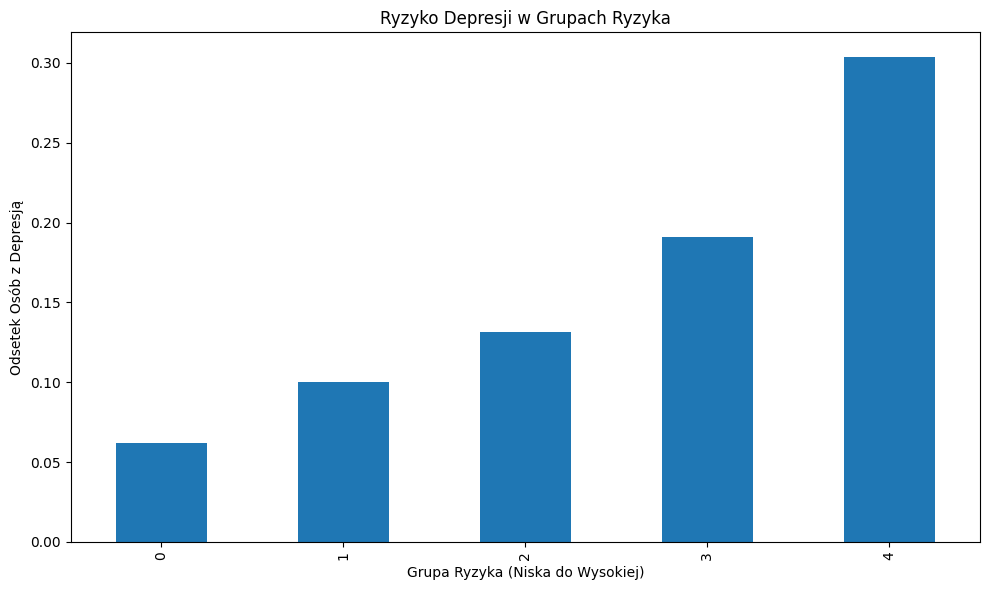


Charakterystyka grupy niskiego ryzyka:
      MJANDCOKE  ALCFMFPB   HEALTH2  IRPRVHLT  CRIMEHIST  WORKFORCE  \
mean   0.001386  1.999538  1.548730  1.248499   0.038799   0.311316   
std    0.037208  0.021492  0.572841  0.432242   0.193160   0.463139   

      ANYATTACK  EDU_DUMMY  IRSEX    CATAG2  
mean        0.0   0.141339    1.0  1.544573  
std         0.0   0.348452    0.0  0.804605  

Charakterystyka grupy wysokiego ryzyka:
      MJANDCOKE  ALCFMFPB   HEALTH2  IRPRVHLT  CRIMEHIST  WORKFORCE  \
mean   0.856674  1.866511  2.541452  1.390164   0.282436   0.620609   
std    0.350487  0.340183  0.856663  0.487901   0.450290   0.485349   

      ANYATTACK  EDU_DUMMY     IRSEX    CATAG2  
mean   0.178923   0.344262  1.866979  1.890867  
std    0.383377   0.475238  0.339677  0.767050  


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Utworzenie klasyfikatora grup ryzyka
def assign_risk_group(probabilities, n_groups=5):
    percentiles = np.linspace(0, 100, n_groups+1)[1:-1]
    thresholds = np.percentile(probabilities, percentiles)
    
    def classifier(prob):
        return np.searchsorted(thresholds, prob)
    
    return classifier

# 2. Analiza charakterystyk grup ryzyka
def analyze_risk_group(test_data, risk_groups, target_group):
    group_mask = (np.array(risk_groups) == target_group)
    group_data = test_data[group_mask]
    group_characteristics = group_data.agg(['mean', 'std'])
    return group_characteristics

def visualize_risk_groups(probabilities, true_labels, n_groups=5):
    risk_group_classifier = assign_risk_group(probabilities, n_groups)
    risk_groups = [risk_group_classifier(prob) for prob in probabilities]
    
    risk_group_counts = pd.Series(risk_groups).value_counts().sort_index()
    print("Liczebność grup ryzyka:")
    print(risk_group_counts)
    
    risk_df = pd.DataFrame({
        'risk_group': risk_groups,
        'actual_depression': true_labels
    })
    
    depression_risk = risk_df.groupby('risk_group')['actual_depression'].mean()
    print("\nRyzyko depresji w grupach:")
    print(depression_risk)
    
    plt.figure(figsize=(10, 6))
    depression_risk.plot(kind='bar')
    plt.title('Ryzyko Depresji w Grupach Ryzyka')
    plt.xlabel('Grupa Ryzyka (Niska do Wysokiej)')
    plt.ylabel('Odsetek Osób z Depresją')
    plt.tight_layout()
    plt.show()
    
    return risk_groups, risk_group_counts, depression_risk

def main(test_results, n_groups=5):
    probabilities = test_results['predicted_prob']
    true_labels = test_results['depression_binary']
    
    features = [
        'MJANDCOKE', 'ALCFMFPB', 'HEALTH2', 'IRPRVHLT', 
        'CRIMEHIST', 'WORKFORCE', 'ANYATTACK', 
        'EDU_DUMMY', 'IRSEX', 'CATAG2'
    ]
    test_data = test_results[features]
    
    risk_groups, group_counts, depression_risk = visualize_risk_groups(probabilities, true_labels, n_groups)
    low_risk_chars = analyze_risk_group(test_data, risk_groups, 0)
    high_risk_chars = analyze_risk_group(test_data, risk_groups, n_groups - 1)
    
    print("\nCharakterystyka grupy niskiego ryzyka:")
    print(low_risk_chars)
    print("\nCharakterystyka grupy wysokiego ryzyka:")
    print(high_risk_chars)
    
    return {
        'risk_groups': risk_groups,
        'group_counts': group_counts,
        'depression_risk': depression_risk,
        'low_risk_chars': low_risk_chars,
        'high_risk_chars': high_risk_chars
    }

results = main(test_results)

Grupa niskiego ryzyka depresji charakteryzuje się:
- **MJANDCOKE**: bardzo niskim odsetkiem osób zażywających narkotyki: **średnia 0.0014**            (gdzie 0: Never used, 1: Used)
- **ALCFMFPB**: bardzo niskim odsetkiem osób pijących alkohol: **średnia 1.99**                     (gdzie: 1: Pijący, 2: Niepijący)
- **HEALTH2**: ogólnym poczuciem zdrowia między Excellent a Very Good: **średnia 1.53**             (gdzie 1: Excellent, 2: Very Good, 3: Good, 4: Fair/Poor)
- **IRPRVHLT**: znaczna większość osób posiada prywatne ubezpieczenie zdrowotne: **średnia 1.23**   (gdzie 1: posiada, 2: nieposiada)
- **CRIMEHIST**: osobami w znacznej większości niearesztowanymi: **średnia 0.04**                   (gdzie 0: Never arrested, 1: arrested)
- **ANYATACK**: osobami, które nie dopuściły się napaści: **średnia 0.0**
- **IRSEX**: mężczyznami: **średnia 1.0**
- **CATAG2**: osobami młodszymi: **średnia 1.55**                                                   (gdzie 1: 12-17 lat, 2: 18-25 lat, 3: 26+)

Grupa niskiego ryzyka depresji charakteryzuje się:
- **MJANDCOKE**: bardzo wysokim odsetkiem osób zażywających narkotyki: **średnia 0.85** (gdzie 0: Never used, 1: Used)
- **ALCFMFPB**: niskim odsetkiem osób pijących alkohol: **średnia 1.85** (gdzie: 1: Pijący, 2: Niepijący)
- **HEALTH2**: ogólnym poczuciem zdrowia między Very Good a Good: **średnia 2.53** (gdzie 1: Excellent, 2: Very Good, 3: Good, 4: Fair/Poor)
- **IRPRVHLT**: większość osób posiada prywatne ubezpieczenie zdrowotne: **średnia 1.39** (gdzie 1: posiada, 2: nieposiada)
- **CRIMEHIST**: osobami w większości niearesztowanymi: **średnia 0.27** (gdzie 0: Never arrested, 1: arrested)
- **ANYATACK**: osobami, które dopuściły się napaści: **średnia 0.19**
- **IRSEX**: głównie kobietami: **średnia 1.87** (gdzie 1: Male, 2: Female)
- **CATAG2**: osobami starszymi niż w grupie niskiego ryzyka depresji: **średnia 1.88** (gdzie 1: 12-17 lat, 2: 18-25 lat, 3: 26+)

Model drzewa decyzyjnego, który pozwoli przypisanie nowej obserwacji do jednej z pięciu grup ryzyka. Pozwala nam na wpisanie własnych odpowiedzi do cech.

In [10]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

features = ['MJANDCOKE', 'ALCFMFPB', 'HEALTH2', 'IRPRVHLT', 
            'CRIMEHIST', 'WORKFORCE', 'ANYATTACK', 'EDU_DUMMY', 
            'IRSEX', 'CATAG2']
X = df[features]
y = df["DEPRESSION_CLASS"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

def assign_risk_group(probability):
    if probability < 0.2:
        return 0
    elif probability < 0.4:
        return 1
    elif probability < 0.6:
        return 2
    elif probability < 0.8:
        return 3
    else:
        return 4

def classify_new_observation(new_observation, model, features):
    new_observation_df = pd.DataFrame([new_observation], columns=features)
    probability = model.predict_proba(new_observation_df)[0, 1]
    risk_group = assign_risk_group(probability)
    
    return risk_group
new_observation = {
    'MJANDCOKE': 1,
    'ALCFMFPB': 1,
    'HEALTH2': 3,
    'IRPRVHLT': 2,
    'CRIMEHIST': 0,
    'WORKFORCE': 0,
    'ANYATTACK': 1,
    'EDU_DUMMY': 1,
    'IRSEX': 1,
    'CATAG2': 2
}
# new_observation = {
#     'MJANDCOKE': 1,
#     'ALCFMFPB': 1,
#     'HEALTH2': 4,
#     'IRPRVHLT': 2,
#     'CRIMEHIST': 1,
#     'WORKFORCE': 1,
#     'ANYATTACK': 1,
#     'EDU_DUMMY': 1,
#     'IRSEX': 2,
#     'CATAG2': 2
# }

risk_group = classify_new_observation(new_observation, tree_model, features)
print(f"Nowa obserwacja została przypisana do grupy ryzyka: {risk_group}")

Nowa obserwacja została przypisana do grupy ryzyka: 3


Nowa obserwacja może trafić do jednej z pieciu grup ryzyka depresji.
Ryzyko depresji w grupach:
- 0 - 6.2 %
- 1 - 10.0 %
- 2 - 13.2 %
- 3 - 19.1 %
- 4 - 30.4 %